In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/public-balanced-data/balanced_data.csv
/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


# Steps taken to work on this project

* 1. On analysis the very first observation was that our dataset had some missing values , this was dealt by imputing medians over grouped data in the dataset to ensure that correct medians were being put for each stock_id and date_id
* 2. Another problem with the dataset as mentioned in the description was that not all time buckets had all stock_id , i.e. there were completely missing records in the dataset , again used median to deal with this as given in the code 
* 3. As the above steps were consuming a lot of time decided to publish the processed data as public and directly add it for usage 
* 4. Then proceeded to make some extra features that were useful specifically the time related features as they are highly informative about the market's behavior 
* 5. While performing EDA using sweetviz , found out that date_id , time_id and seconds_in_bucket were highly correlated , used this and self observation to find out the relation between the three as :  date_id = time_id/55 as int type and seconds_in_bucket=(time_id%55)*10 
* 6. Initially tried working on a LSTM model but found it difficult to implement the API , so then decided to switch on Lightgbm regressor as it works well with large datasets 
* 7. Tuned the hyperparameters of LGBM using optuna library while keeping the objective to minimise mean absolute error and implemented the API with the same model 
* 8. Also trained XGB model but after removing outliers as an experiment , but LGB proved to be better 
* 9. Finally Implemented the API along with Lightgbm model.


In [7]:
dataset =pd.read_csv('/kaggle/input/public-balanced-data/balanced_data.csv')

In [8]:
# Function to create extra useful features 
def other_features(df):
    df["dow"] = df["date_id"] % 7  # Day of the week 
    df['time_to_market_close'] = 540 - df['seconds_in_bucket']
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    

In [9]:
other_features(dataset)

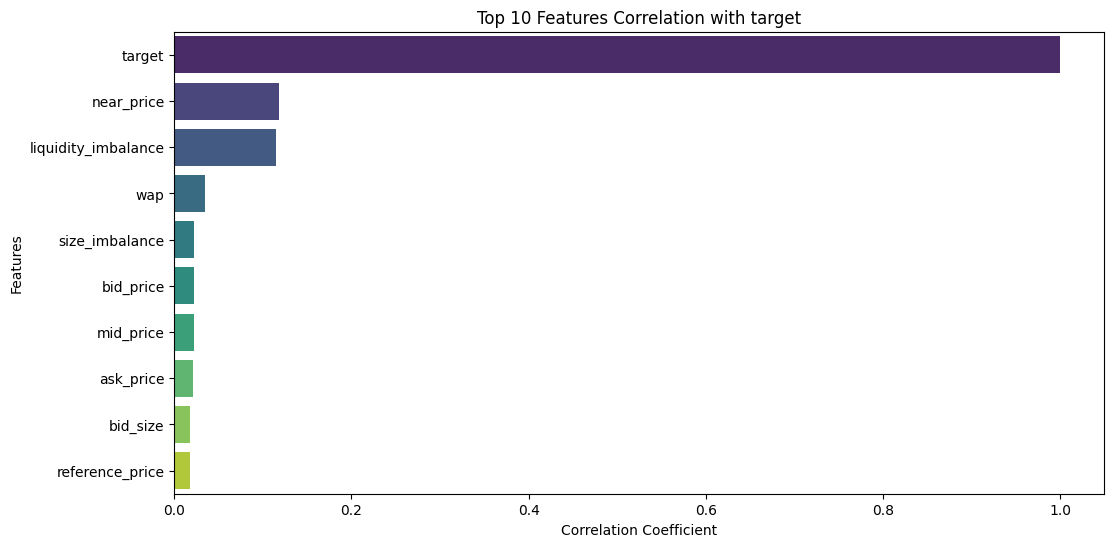

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns 
data = dataset

# Assuming 'target' is the column name of your target variable
target_variable = 'target'

# Calculate correlation between features and the target variable
correlation_matrix = data.corr()[[target_variable]]

# Sort features based on their absolute correlation with the target variable
sorted_features = correlation_matrix.abs().sort_values(by=target_variable, ascending=False)

# Select the top N features to plot
top_n_features = 10  # Change this based on your preference
selected_features = sorted_features.head(top_n_features)

# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=selected_features[target_variable], y=selected_features.index, palette="viridis")
plt.title(f'Top {top_n_features} Features Correlation with {target_variable}')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()


In [11]:


def plot_columns_vs_target(dataset, target_column):
    # Set seaborn style for better visuals
    sns.set(style="whitegrid")
    
    # Get all columns except the target column
    feature_columns = [col for col in dataset.columns if col != target_column]

    # Determine the number of rows and columns for subplots
    num_cols = 3  # Adjust the number of columns as needed
    num_rows = (len(feature_columns) - 1) // num_cols + 1

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    fig.suptitle(f'Columns vs. {target_column}', y=1.02)

    # Plot each feature column against the target
    for i, col in enumerate(feature_columns):
        row_idx = i // num_cols
        col_idx = i % num_cols

        ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]

        sns.scatterplot(x=col, y=target_column, data=dataset, ax=ax)
        ax.set_title(f'{col} vs. {target_column}')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()



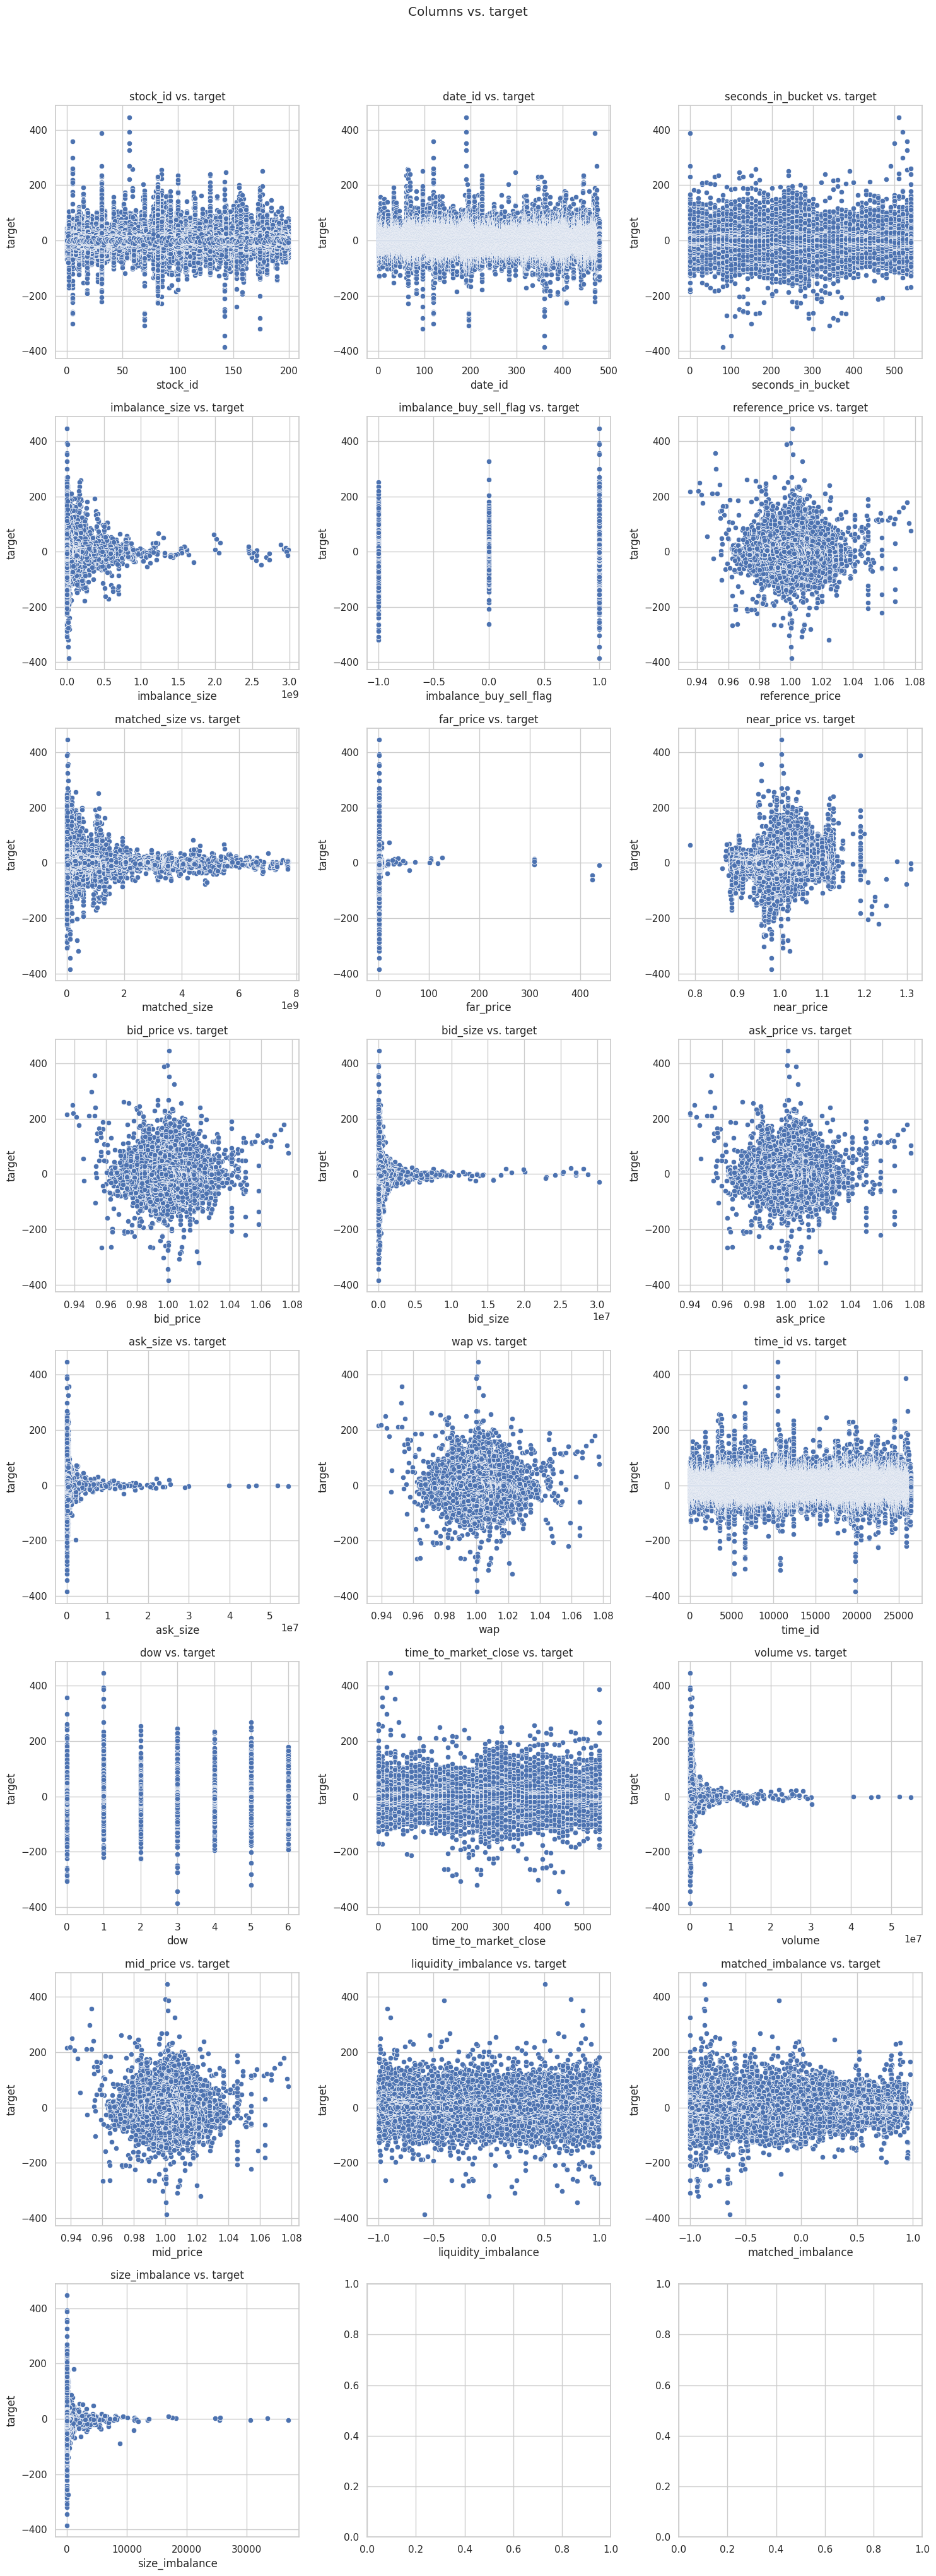

In [12]:
plot_columns_vs_target(dataset, 'target')

In [13]:
columns = dataset.columns
print(columns)

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'dow', 'time_to_market_close',
       'volume', 'mid_price', 'liquidity_imbalance', 'matched_imbalance',
       'size_imbalance'],
      dtype='object')


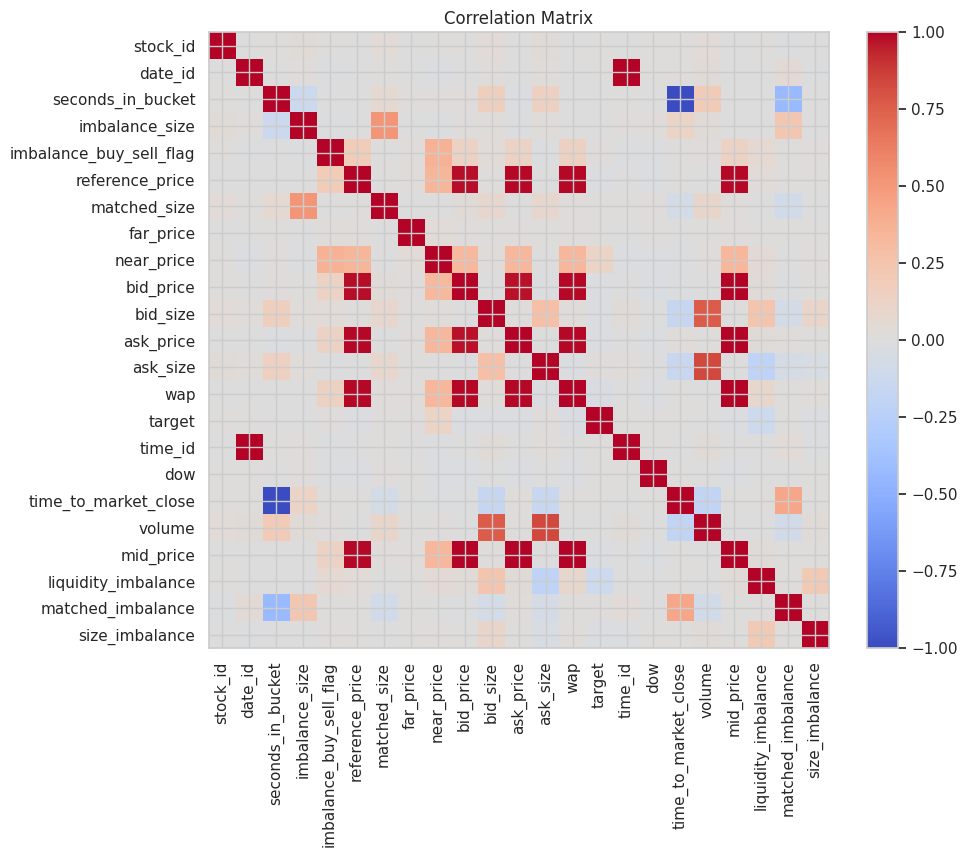

In [14]:
df = dataset
correlation_matrix = df.corr()
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

 **Inferences, Reasoning, and Observations:**

**Stock ID and Imbalance:**

* **Inference:** Specific stocks consistently exhibit higher or lower imbalance levels.
* **Reasoning:** Company fundamentals, industry trends, or individual stock volatility might contribute to this.
* **Observation:** Strong positive correlation between stock_id and imbalance_size in the correlation matrix.

**Time and Target:**

* **Inference:** No clear relationship between time (seconds/minutes) and future price movement, except for reference price decreasing with auction progress.
* **Reasoning:** Short-term time frames within the closing auction might not directly influence future price movements, while reference price decreases could be due to order fulfillment, changing sentiment, or closing pressure.
* **Observation:** Scatter plots of seconds/minutes vs. target showed no clear trend, while seconds_in_bucket had a negative correlation with reference_price in the correlation matrix.

**Imbalance and Price:**

* **Inference:** Larger imbalances are associated with slightly smaller future price movements and lower reference prices.
* **Reasoning:** Oversupply of orders at the current price, potential downward pressure, and decreased liquidity could contribute to this.
* **Observation:** Slight negative trend in imbalance_size vs. target plot and negative correlations of imbalance_size with reference_price and target in the correlation matrix.

**Volume and Price:**

* **Inference:** Higher trading volume shows a weak positive correlation with future price movement.
* **Reasoning:** Increased market participation, liquidity, and confidence in the price might contribute to slightly larger future movements.
* **Observation:** Scatter plot of volume vs. target showed a weak upward trend.

**Market and Price:**

* **Inference:** Rising Dow Jones has a weak positive correlation with future price movement of the individual stock.
* **Reasoning:** Overall market optimism might spill over to specific stocks.
* **Observation:** Weak positive trend in Dow vs. target plot.

**Liquidity Imbalance and Price:**

* **Inference:** Larger buy-side imbalance (liquidity imbalance) is associated with slightly smaller future price movements.
* **Reasoning:** Challenges in finding matching sell orders to fulfill the imbalance could result in slower price movements.
* **Observation:** Weak negative trend in liquidity imbalance vs. target plot.


In [15]:

df = dataset


In [16]:
counter = 0

# Attempt to implement LGBM model along with API implemtation 

In [17]:
import optuna 
from sklearn.metrics import mean_absolute_error

In [18]:
df['revealed_target'] = df.shift(11000)['target'].loc[df.index]
train_df = df[df['date_id']<=477]
train_df = train_df.fillna(0)
train_df = train_df.reset_index(drop=True)
Y = pd.DataFrame({
    'target':train_df['target'].values})
X = train_df.drop(columns = ['target','time_id'])
test_df = df[df['date_id']>477]
test_df = test_df.fillna(0)
test_df = test_df.reset_index(drop=True)
Y_t = pd.DataFrame({
    'target':test_df['target'].values})
X_t = test_df.drop(columns = ['target','time_id'])
from lightgbm import LGBMRegressor as LGBM
from xgboost import XGBRegressor as XGB
import optuna



In [19]:
test_df['date_id'].unique()

array([478, 479, 480])

# Primary model : LIGHTGBM Implemented below 

* LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

 1. Faster training speed and higher efficiency.
 2. Lower memory usage.
 3. Better accuracy.
 4. Support of parallel, distributed, and GPU learning.
 5. Capable of handling large-scale data.
 
 
 * Our reasons to use lightgbm were primarily the fact that our dataset was large and consumed a lot of memory when trained with other models , also its faster when tuning the parameters and training on data.

In [20]:
import lightgbm as lgb

In [21]:
SEED = 42 

In [22]:
estimator = lgb.LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample_for_bin=200000, 
    objective='mae', 
    class_weight=None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=SEED, 
    n_jobs=-1, 
    importance_type='split',
    force_row_wise=True
)


In [23]:

val_predictions = np.zeros(len(X))
val_scores = []

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

In [25]:

splitter =TimeSeriesSplit(5).split(X, Y)


In [26]:

for fold, (train_idx, val_idx) in enumerate(splitter):
    model = clone(estimator)

    # Define train and val set
    X_train = X.iloc[train_idx]
    Y_train = Y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    Y_val = Y.iloc[val_idx]

    model.fit(X_train, Y_train)
    val_scores.append(mean_absolute_error(model.predict(X_val), Y_val))

In [27]:
 val_scores

[7.2105436376412415,
 6.658507001054173,
 5.904127642580665,
 6.181186034186483,
 5.732440053497607]

In [28]:
model.fit(X,Y)

LGBMRegressor(force_row_wise=True, objective='mae', random_state=42)

In [29]:
train_pred = model.predict(X)
new_df = pd.DataFrame({
    'stock_id': X['stock_id'].values,
    'target': train_pred
})



In [30]:
from sklearn.metrics import mean_absolute_error

In [31]:

mae = mean_absolute_error(model.predict(X_t),Y_t)

In [32]:
df['target'].describe()

count    5.291000e+06
mean    -4.857943e-02
std      9.405331e+00
min     -3.852898e+02
25%     -4.500151e+00
50%     -6.020069e-02
75%      4.349947e+00
max      4.460704e+02
Name: target, dtype: float64

In [33]:
print(mae)


5.0095767135111755


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5291000 entries, 0 to 5290999
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  float64
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  dow                      int64  
 17  time_to_market_close     int64  
 18  volume                   float64
 19  mid_price                float64
 20  liquidity_imbalance      float64
 21  matched_

# API implemented using tuned lightgbm

* The purpose of API is to stop our model from peeking forward in time.  In the stock market context, if the model could access future stock prices during training, it might inadvertently learn patterns or trends that wouldn't be available in a real-world scenario.

* Using an API to restrict the data available to the model during training to historical information helps ensure that the model's predictions are based on past patterns and trends, making it more applicable to real-world scenarios where future data is unknown at the time of prediction. This approach aims to enhance the model's generalization and reliability in making predictions for stock market prices.

* The following API , provides data in intervals of seconds_in_bucket , i.e provides data for 200 stocks at seconds_in_bucket == 0 first , the seconds_in_bucket == 10 after that and so on , once all the seconds are exhausted it starts providing test data for the next day , also it provided revealed targets only at the beginning of a day , that is when seconds_in_bucket == 0 (reason to use cache)

* We use another dataframe to store all the results so that we can evaluate them later on. Since the API is just for not peeking forward in time we can evaluate using the provided data itself 

In [35]:
import optiver2023
import pandas as pd
import numpy as np


env = optiver2023.make_env()
iter_test = env.iter_test()
counter = 0
cache =pd.DataFrame()

# Creating an empty DataFrame to store predictions and revealed targets
result_df = pd.DataFrame(columns=['stock_id','seconds_in_bucket','Revealed_Target', 'Predicted_Target'])

for (test, revealed_targets, sample_prediction) in iter_test:
    test = test.drop(columns=['row_id', 'currently_scored'])
    test['time_id'] = test['date_id'] * 55 + test['seconds_in_bucket'] * 10
    test = test.drop(columns=['time_id'])
    if counter == 0:
        cache = revealed_targets
    other_features(test)    
    test['revealed_target'] = (cache['revealed_target'].iloc[counter * 200:(counter + 1) * 200]).astype('float64')
    test = test.reset_index(drop=True)
    test = test.fillna(0)
    test_data = {'Revealed_Target': (cache['revealed_target'].iloc[counter * 200:(counter + 1) * 200]).astype('float64')}
    reveal = pd.DataFrame(test_data)
    # Store information in the result DataFrame
    new_row = pd.DataFrame({
        'stock_id':test['stock_id'].values,
        'seconds_in_bucket': counter*10,
        'Revealed_Target':reveal['Revealed_Target'].values,
        'Predicted_Target': np.nan  # Placeholder for now 
    })
    print(counter)
    counter += 1
    counter = counter % 55
    new_row.reset_index(drop = True)
    # Making predictions and updating the result DataFrame
    Y_pred = model.predict(test)
    new_row['Predicted_Target'] = Y_pred.astype('float64')
    result_df = pd.concat([result_df, new_row], ignore_index=True)

    # Updating the sample prediction
    sample_prediction['target'] = Y_pred.astype('float64')
    env.predict(sample_prediction)

# Save the result DataFrame to a CSV file
result_df.to_csv('predictions_and_targets.csv', index=False)


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


In [36]:
result_copy = result_df

In [37]:
result_df['Revealed_Target'] = result_df['Revealed_Target'].shift(-11000)
result_df.iloc[-11000:, result_df.columns.get_loc('Revealed_Target')] = test_df['target'].tail(11000).values

In [56]:
mae = mean_absolute_error(result_df['Predicted_Target'], result_df['Revealed_Target'])
print(f"Mean Absolute Error for  the  targets: {mae}")

Mean Absolute Error for  the  targets: 5.66085793260647


# Below these are other tried implementations and Ideas that were ultimately not chosen. 

In [39]:
# outers = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
#        'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
#        'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
#        'ask_size', 'wap','time_id', 'dow', 'seconds', 'minute',
#        'time_to_market_close', 'volume', 'mid_price', 'liquidity_imbalance',
#        'matched_imbalance', 'size_imbalance']

In [40]:
# # Counting the outliers 
# import pandas as pd

# def count_outliers(df, multiplier=1.5):
#     outlier_counts = pd.Series()

#     for column in outers:
#         # Calculate IQR for the column
#         q1 = df[column].quantile(0.25)
#         q3 = df[column].quantile(0.75)
#         iqr = q3 - q1
#         # Define the upper and lower bounds for outliers
#         lower_bound = q1 - multiplier * iqr
#         upper_bound = q3 + multiplier * iqr
#         # Count the number of outliers in the column
#         outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
#         outlier_counts[column] = len(outliers)

#     return outlier_counts




In [41]:
# import pandas as pd

# def set_outlier_caps(df, multiplier=1.5, cap_method='both'):
#     df_capped = df.copy()

#     for column in outers:
#         # Calculate IQR for the column
#         q1 = df[column].quantile(0.25)
#         q3 = df[column].quantile(0.75)
#         iqr = q3 - q1

#         # Define the upper and lower bounds for outliers
#         lower_bound = q1 - multiplier * iqr
#         upper_bound = q3 + multiplier * iqr

#         # Set caps based on the specified method
#         if cap_method == 'both':
#             df_capped[column] = df_capped[column].clip(lower=lower_bound, upper=upper_bound)
#         elif cap_method == 'lower':
#             df_capped[column] = df_capped[column].clip(lower=lower_bound)
#         elif cap_method == 'upper':
#             df_capped[column] = df_capped[column].clip(upper=upper_bound)

#     return df_capped




In [42]:
# df = set_outlier_caps(dataset)  for out lier  removed data

In [43]:
# df['revealed_target'] = df.shift(11000)['target'].loc[df.index]
# train_df = df[df['date_id']<=477]
# train_df = train_df.fillna(0)
# train_df = train_df.reset_index(drop=True)
# Y = train_df['target'].values
# X = train_df.drop(columns = ['target'])
# test_df = df[df['date_id']>477]
# test_df = test_df.fillna(0)
# test_df = test_df.reset_index(drop=True)
# Y_t = test_df['target'].values
# X_t = test_df.drop(columns = ['target'])
# from lightgbm import LGBMRegressor as LGBM
# from xgboost import XGBRegressor as XGB
# import optuna



# Tuning hyperparameters for XGB

In [44]:

# def objective(trial):
#     params = {
#         'objective': 'reg:squarederror',
#         'eval_metric': 'mae',
#         'booster': 'gbtree',
#         'n_estimators': 100,
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'max_depth': trial.suggest_int('max_depth', 2, 10),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'lambda': trial.suggest_float('lambda', 1e-8, 10.0),
#         'alpha': trial.suggest_float('alpha', 1e-8, 10.0),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1, 10)
#     }

#     model = XGB(**params)
#     model.fit(X, Y, eval_set=[(X_t, Y_t)], early_stopping_rounds=10, verbose=False)

#     Y_pred = model.predict(X_t)
#     mae = mean_absolute_error(Y_t, Y_pred)
#     return mae

# study = optuna.create_study(direction='minimize')  # minimize for MAE
# study.optimize(objective, n_trials=50)

# # Print the best trial
# print('Best trial:')
# trial = study.best_trial
# print('Value (MAE): {}'.format(trial.value))
# print('Params: ')
# for key, value in trial.params.items():
#     print('{}: {}'.format(key, value))

# # Train the final model with the best hyperparameters
# best_params = study.best_trial.params
# xgb_model = xgb.XGBRegressor(**best_params)
# xgb_model.fit(X, Y)


In [45]:
# #Best XGB parameters with outliers removed except for targets 
# xgb_params ={'learning_rate': 0.03847351225144945, 'max_depth': 10, 'subsample': 0.6189164717777285, 'colsample_bytree': 0.6094835684116658, 'lambda': 9.53694259770177, 'alpha': 9.151057398262493, 'min_child_weight': 7.138322668669892}

# Time series and LSTM implementation  ( Scrapped due to API giving data in different order)

In [46]:

#             scaler = MinMaxScaler((-1,1))
#             scaler.fit(X)
#             X_std = scaler.transform(X)
#             win_length = 200
#             batch_size = 100
#             num_features = 20
#             stride = 200
#             train_generator = TimeseriesGenerator(X_std,Y,length=win_length,sampling_rate=1,batch_size=batch_size)
#             model = Sequential()
#             model.add(LSTM(64, input_shape=(win_length, num_features), return_sequences=True))
#             model.add(LeakyReLU(alpha=0.5))
#             model.add(Dropout(0.3))
#             model.add(LSTM(32, return_sequences=False))
#             model.add(Dropout(0.3))
#             model.add(Dense(1))
#             model.compile(loss=tf.losses.MeanSquaredError(),
#             optimizer=tf.optimizers.Adam(),
#             metrics=[tf.metrics.MeanAbsoluteError()],
#             run_eagerly = True)
#             history = model.fit(train_generator, epochs=1,
#             shuffle=False)
#             X_t_std = scaler.transform(X_t)
#             dates = test_df.iloc[win_length:]['date_id'].values
#             seconds = test_df.iloc[win_length:]['seconds_in_bucket'].values
#             test_generator = TimeseriesGenerator(X_t_std,Y_t,length=win_length,sampling_rate=1,batch_size=batch_size)     
#             predictions = model.predict(test_generator).flatten()
#             print(len(predictions))
#             predictions_df = pd.DataFrame({
#                 'time_id': (dates*55) +(seconds*10),
#                 'predicted': predictions,
#                 'stock_id': stock_id,
#                 'actual': test_df.iloc[win_length:]['target'].values,
#             })
#             print(predictions_df.head())
#             all_predictions = pd.concat([all_predictions, predictions_df], ignore_index=True)
#             print(counter)
#             counter+=1

In [47]:
# from sklearn.metrics import mean_absolute_error 
# mae = mean_absolute_error(all_predictions['predicted'],all_predictions['actual'])

In [48]:
# print(mae)

In [49]:
# all_predictions = all_predictions.drop(columns=['target'])

In [50]:
# all_predictions.head()

# Implementing the testing using API given  ( yet to be done correctly )

In [51]:
#     import optiver2023
#     env = optiver2023.make_env()
#     iter_test = env.iter_test()
#     for (test, revealed_targets, sample_prediction) in iter_test:
#         counter=0
#         all_predictions = pd.DataFrame(columns=[ 'time_id', 'row_id', 'target','stock_id'])
#         missing_col = ['imbalance_size', 'matched_size', 'reference_price', 'far_price', 'near_price',
#                'bid_price', 'ask_price', 'wap']
#         test[missing_col] = test.groupby(['date_id','stock_id'])[missing_col].transform(lambda x: x.fillna(x.median()))
#         test[missing_col] = test.groupby(['stock_id'])[missing_col].transform(lambda x: x.fillna(x.median()))
#         test = test.reset_index(drop=True)
#         revealed_targets = revealed_targets.dropna()
#         revealed_targets = revealed_targets.reset_index(drop=True)
#         test['revealed_target'] =revealed_targets['revealed_target'].iloc[:33000]
#         test = test.drop(columns=['currently_scored'])
#         other_features(test)
#         #padded the necessary data to get all predictions 
# #         test = pd.concat([test_p,test])
#         test = test.reset_index(drop=True)
#             df = dataset[dataset['stock_id'] == stock_id]
#             df['revealed_target'] = df.shift(55)['target'].loc[df.index]
#             train_df = df[df['date_id']<=477]
#             train_df = train_df.fillna(0)
#             train_df = train_df.reset_index(drop=True)
#             train_df = train_df
#             Y = train_df['target'].values
#             X = train_df.drop(columns = ['target'])
#             scaler = MinMaxScaler((-1,1))
#             scaler.fit(X)
#             X_std = scaler.transform(X)
#             win_length = 200
#             batch_size = 
#             num_features = 20
#             stride = 55
#             train_generator = TimeseriesGenerator(X_std,Y,length=win_length,sampling_rate=1,batch_size=batch_size)
#             model = Sequential()
#             model.add(LSTM(64, input_shape=(win_length, num_features), return_sequences=True))
#             model.add(LeakyReLU(alpha=0.5))
#             model.add(Dropout(0.3))
#             model.add(LSTM(32, return_sequences=False))
#             model.add(Dropout(0.3))
#             model.add(Dense(1))
#             model.compile(loss=tf.losses.MeanSquaredError(),
#             optimizer=tf.optimizers.Adam(),
#             metrics=[tf.metrics.MeanAbsoluteError()],
#             run_eagerly = True)
#             history = model.fit(train_generator, epochs=1,
#             shuffle=False)
#             test_df= test[test['stock_id']==stock_id]
#             test_df = test_df.reset_index(drop=True)
#             print(test_df.shape)
#             feature_order = X.columns.tolist()
#             X_t = test_df.drop(columns = ['row_id'])
#             X_t = X_t.reindex(columns=feature_order)
#             X_t_std = scaler.transform(X_t)
#             dummy_targets = np.zeros(len(X_t))
#             dates = test_df.iloc[win_length:]['date_id'].values
#             seconds = test_df.iloc[win_length:]['seconds_in_bucket'].values
#             test_generator = TimeseriesGenerator(X_t_std,dummy_targets,length=win_length,sampling_rate=1,batch_size=batch_size)     
#             predictions = model.predict(test_generator).flatten()
#             print(len(predictions))
#             predictions_df = pd.DataFrame({
#                 'time_id': (dates*55) +(seconds*10),
#                 'row_id': test_df.iloc[win_length:]['row_id'].values, 
#                 'target': predictions,
#                 'stock_id': stock_id,
#             })
#             print(predictions_df.head())
#             all_predictions = pd.concat([all_predictions, predictions_df], ignore_index=True)
#             print(counter)
#             counter+=1
#         all_predictions = all_predictions.sort_values(by=['time_id', 'stock_id'])
#         all_predictions = all_predictions.reset_index(drop=True)
#         results = all_predictions['target']
#         # Convert results to a numpy array of type float64
#         results_array = np.array(results, dtype=np.float64)
#         sample_prediction['target'] = results_array
#         env.predict(sample_prediction)

In [52]:
# time_taken = time.time() - now_time
# print("Time_Taken = " , time_taken)

# On observing and performing operations we found that time_id gives both date_id and seconds_in_bucket i.e.   date_id = time_id/55 as int type and seconds_in_bucket=(time_id%55)*10 **

# Also max seconds_in_buckets for a date_id are 540 implies that we are only given data over 9 min at 10 sec interval 

In [53]:
# lgb_params = {
#         "objective": "mae",
#         "n_estimators": 6000, # Keep high for more opportunities to learn
#         "num_leaves": 512, # Increase to allow the model to learn more complex patterns
#         "subsample": 0.65, # Increase to provide more data points in each tree
#         "colsample_bytree": 0.65, # Increase to provide more feature coverage in each tree
#         "learning_rate": 0.007, # Lower to make more conservative updates, can lead to better generalization
#         "n_jobs": 4,
#     }

In [54]:

#     import optiver2023
#     env = optiver2023.make_env()
#     iter_test = env.iter_test()
#     for (test, revealed_targets, sample_prediction) in iter_test:
#         counter=0
#         all_predictions = pd.DataFrame(columns=[ 'time_id', 'row_id', 'target','stock_id'])
#         missing_col = ['imbalance_size', 'matched_size', 'reference_price', 'far_price', 'near_price',
#                'bid_price', 'ask_price', 'wap']
#         test[missing_col] = test.groupby(['date_id','stock_id'])[missing_col].transform(lambda x: x.fillna(x.median()))
#         test[missing_col] = test.groupby(['stock_id'])[missing_col].transform(lambda x: x.fillna(x.median()))
#         test = test.reset_index(drop=True)
#         revealed_targets = revealed_targets.dropna()
#         revealed_targets = revealed_targets.reset_index(drop=True)
#         test['revealed_target'] =revealed_targets['revealed_target'].iloc[:33000]
#         test = test.drop(columns=['currently_scored'])
#         other_features(test)
#         #padded the necessary data to get all predictions 
# #         test = pd.concat([test_p,test])
#         test = test.reset_index(drop=True)
#         stock_ids = test['stock_id'].unique()
#         for stock_id in stock_ids:
#             df = dataset[dataset['stock_id'] == stock_id]
#             df['revealed_target'] = df.shift(55)['target'].loc[df.index]
#             train_df = df
#             train_df = train_df.fillna(0)
#             Y = train_df['target'].values
#             X = train_df.drop(columns = ['target','row_id'])
#             scaler = MinMaxScaler((-1,1))
#             scaler.fit(X)
#             X_std = scaler.transform(X)
#             test_df= test[test['stock_id']==stock_id]
#             feature_order = X.columns.tolist()
#             X_t = test_df.drop(columns = ['row_id'])
#             X_t = X_t.reindex(columns=feature_order)
#             X_t_std = scaler.transform(X_t)
#             train_data = lgb.Dataset(X, label=Y)
#             num_round = 5
#             model = lgb.train(lgb_params, train_data, num_round)
#             predictions = model.predict(X_t_std).flatten()
#             predictions_df = pd.DataFrame({
#                 'time_id': test_df['time_id'].values, 
#                 'row_id': test_df['row_id'].values, 
#                 'target': predictions,
#                 'stock_id': stock_id,
#             })
#             all_predictions = pd.concat([all_predictions, predictions_df], ignore_index=True)
#             print(counter)
#             counter+=1
#         all_predictions = all_predictions.sort_values(by=['time_id', 'stock_id'])
#         all_predictions = all_predictions.groupby('time_id').apply(lambda x: x.sort_values('stock_id'))
#         all_predictions = all_predictions.reset_index(drop=True)
#         results = all_predictions['target']
#         # Convert results to a numpy array of type float64
#         results_array = np.array(results, dtype=np.float64)
#         sample_prediction['target'] = results_array
#         env.predict(sample_prediction)